In [14]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import akshare as ak
from utils.utils import normalize, func_list
import warnings
warnings.filterwarnings('ignore')


In [15]:
FILE_PATH = '../data/raw/macro_data.xlsx'
START_DATE = '2010-01-01'
END_DATE = '2020-12-31'
EXPAND=365

In [16]:
def get_macro_data(file_path, start_date, end_date, expand=None):
    start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
    if expand:
        start_date = start_date - pd.Timedelta(expand, 'd')
    df = pd.read_excel(file_path)
    print(f'Features: {list(df.columns[1:])}')
    df.columns = ['date'] + [f'mf{i+1}' for i in range(df.shape[1] - 1)]
    df['date'] = pd.to_datetime(df['date'])

    df_trade_date = ak.tool_trade_date_hist_sina()
    trade_date_list = pd.to_datetime(df_trade_date['trade_date']).values
    df = df[df['date'].isin(trade_date_list)]
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    df = df.sort_values(by='date').reset_index(drop=True)
    num_null = df.isnull().sum().sum()
    if num_null == 0:
        print('There is no NAs.')
    elif num_null > 0:
        print(f'There are {num_null} NAs.')
        print('Filling NAs with forward method.')
        df = df.fillna(method='ffill')
    
    return df

In [17]:
df_macro = get_macro_data(FILE_PATH, START_DATE, END_DATE, expand=EXPAND)
print('Unnormalized raw macro data.')
df_macro.head()

Features: ['中间价:美元兑人民币', 'SHIBOR:隔夜', 'SHIBOR:1年', '上证综合指数', '沪深300指数', '成交量:上证综合指数', '成交量:沪深300', '上证国债指数', '上证企债指数']
There are 1 NAs.
Filling NAs with forward method.
Unnormalized raw macro data.


,date,mf1,mf2,mf3,mf4,mf5,mf6,mf7,mf8,mf9
0,2009-01-05,6.8367,0.9086,2.3003,1880.716,1882.959,67.136715,48.187020,121.217,132.829
1,2009-01-06,6.8384,0.8967,2.2768,1937.145,1942.795,99.066756,70.974097,121.180,132.922
2,2009-01-07,6.8389,0.8894,2.2512,1924.012,1931.178,92.360086,59.702167,121.120,132.974
3,2009-01-08,6.8375,0.8829,2.2293,1878.181,1887.991,80.374000,53.446490,121.192,133.220
4,2009-01-09,6.8363,0.8363,2.2003,1904.861,1918.365,71.224779,47.407216,121.221,133.357


In [18]:
## 删除'中间价:美元兑人民币'和'SHIBOR:隔夜'
df_macro = df_macro.drop(columns=['mf1', 'mf2'])

In [19]:
def extend_macro_data(df, func_list=[]):
    '''
    construct features based on basic features
    include: pctchange + func_list
    drop raw absolute-valued features
    '''
    df = df.copy()
    features = df.drop(columns=['date']).columns
    for func in func_list:
        df_tmp = df_macro[features].transform(func)
        df_tmp.columns = [col + func.__name__ for col in features]
        df = pd.concat([df, df_tmp], axis=1)

    return df.drop(columns = features)

In [20]:
df_extended_macro = extend_macro_data(df_macro, func_list)
df_extended_macro = df_extended_macro[(df_extended_macro['date'] >= START_DATE) &
                                      (df_extended_macro['date'] <= END_DATE)]

df_extended_macro = df_extended_macro.reset_index(drop=True)
print('Unnormalized extended macro data.')
df_extended_macro.head()

Unnormalized extended macro data.


,date,mf3roc,mf4roc,mf5roc,mf6roc,mf7roc,mf8roc,mf9roc,mf3macd,mf4macd,...,mf7varcoef,mf8varcoef,mf9varcoef,mf3slope,mf4slope,mf5slope,mf6slope,mf7slope,mf8slope,mf9slope
0,2010-01-04,0.468813,-0.639215,-1.549678,-31.259933,-26.536865,-0.031052,0.648198,0.004212,5.503382,...,0.287728,0.000801,0.001985,0.000562,-5.559790,-8.042418,-2.173080,-1.478505,-0.005883,0.040619
1,2010-01-05,0.450893,-1.051086,-2.180683,-41.598544,-36.025449,-0.120883,0.524084,0.003989,10.991583,...,0.205730,0.000857,0.002081,0.000503,-3.259919,-5.580322,-0.438414,-0.298041,-0.008582,0.043482
2,2010-01-06,0.450893,-2.331465,-3.464454,-11.599286,-13.979002,-0.148573,0.536685,0.003768,12.935448,...,0.193569,0.000884,0.002193,0.000431,-1.065753,-2.942779,0.294218,0.236965,-0.009703,0.046887
3,2010-01-07,0.633674,-3.151307,-4.209774,-6.137753,-3.123704,-0.098830,0.600063,0.003951,9.409890,...,0.191379,0.000914,0.002267,0.000424,-0.071939,-1.692961,1.072726,0.694556,-0.011622,0.049010
4,2010-01-08,0.789579,-1.344963,-2.091671,-14.525287,-11.282960,-0.104537,0.832888,0.004393,6.797412,...,0.192457,0.000938,0.002255,0.000466,0.282969,-1.125803,1.155104,0.695497,-0.013121,0.048779


In [21]:
df_extended_macro.iloc[:, 1:] = df_extended_macro.iloc[:, 1:].apply(normalize)
print('Normalized extended macro data.')
df_extended_macro.head()

Normalized extended macro data.


,date,mf3roc,mf4roc,mf5roc,mf6roc,mf7roc,mf8roc,mf9roc,mf3macd,mf4macd,...,mf7varcoef,mf8varcoef,mf9varcoef,mf3slope,mf4slope,mf5slope,mf6slope,mf7slope,mf8slope,mf9slope
0,2010-01-04,0.092240,-0.149257,-0.309390,-0.943921,-0.772084,-1.404218,0.412414,0.054560,0.115629,...,0.973386,-0.570532,0.396645,0.037304,-0.669455,-0.802342,-0.624455,-0.635298,-1.496510,-0.085397
1,2010-01-05,0.084658,-0.216606,-0.404875,-1.196274,-0.979955,-1.764914,0.084734,0.047833,0.244075,...,-0.332760,-0.474010,0.504436,0.023146,-0.406500,-0.576957,-0.107638,-0.113447,-1.638354,0.004635
2,2010-01-06,0.084658,-0.425973,-0.599136,-0.464028,-0.496972,-1.876094,0.118002,0.041194,0.289569,...,-0.526479,-0.427008,0.629409,0.005825,-0.155631,-0.335511,0.110639,0.123064,-1.697262,0.111742
3,2010-01-07,0.161986,-0.560033,-0.711919,-0.330718,-0.259160,-1.676366,0.285330,0.046702,0.207057,...,-0.561361,-0.375238,0.712537,0.004103,-0.042004,-0.221101,0.342584,0.325353,-1.798151,0.178531
4,2010-01-08,0.227944,-0.264660,-0.391405,-0.535448,-0.437909,-1.699278,0.900020,0.059984,0.145914,...,-0.544197,-0.333707,0.699065,0.014157,-0.001426,-0.169182,0.367127,0.325769,-1.876922,0.171259


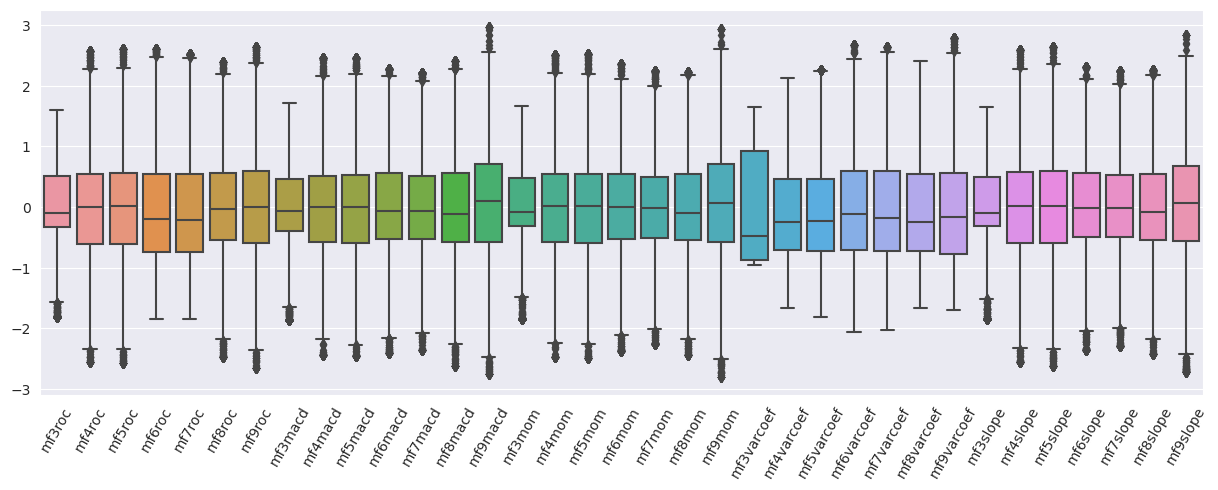

In [22]:
fig = plt.figure(figsize = (15, 5))
sns.boxplot(df_extended_macro)
plt.xticks(rotation=60)
plt.show()

In [23]:
# add the statistical characteristic of factors
df_mean = df_extended_macro.rolling(21).mean()
df_std = df_extended_macro.rolling(21).std()
df_mean = df_mean.fillna(df_mean.mean())
df_std = df_std.fillna(df_std.mean())
df_mean = df_mean.apply(normalize, raw=True)
df_std = df_std.apply(normalize, raw=True)

df_mean.columns = [col + '_mean' for col in df_mean.columns]
df_std.columns = [col + '_std' for col in df_std.columns]
df_extended_macro = df_extended_macro.join(df_mean).join(df_std)

In [24]:
# add seasonal indicator, dummy variable
def month_to_quarter(month):
    if month <=4:
        return 1
    elif month <= 8:
        return 2
    elif month <= 10:
        return 3
    else:
        return 4
df_extended_macro['quarter'] = df_extended_macro['date'].dt.month.apply(lambda x: month_to_quarter(x))
dummies = pd.get_dummies(df_extended_macro['quarter'], prefix = 'quarter')
df_extended_macro = df_extended_macro.join(dummies)
df_extended_macro = df_extended_macro.drop(columns=['quarter'])

In [25]:
df_extended_macro

,date,mf3roc,mf4roc,mf5roc,mf6roc,mf7roc,mf8roc,mf9roc,mf3macd,mf4macd,...,mf4slope_std,mf5slope_std,mf6slope_std,mf7slope_std,mf8slope_std,mf9slope_std,quarter_1,quarter_2,quarter_3,quarter_4
0,2010-01-04,0.092240,-0.149257,-0.309390,-0.943921,-0.772084,-1.404218,0.412414,0.054560,0.115629,...,0.020966,0.024805,0.067655,0.112613,0.018694,0.082287,1,0,0,0
1,2010-01-05,0.084658,-0.216606,-0.404875,-1.196274,-0.979955,-1.764914,0.084734,0.047833,0.244075,...,0.020966,0.024805,0.067655,0.112613,0.018694,0.082287,1,0,0,0
2,2010-01-06,0.084658,-0.425973,-0.599136,-0.464028,-0.496972,-1.876094,0.118002,0.041194,0.289569,...,0.020966,0.024805,0.067655,0.112613,0.018694,0.082287,1,0,0,0
3,2010-01-07,0.161986,-0.560033,-0.711919,-0.330718,-0.259160,-1.676366,0.285330,0.046702,0.207057,...,0.020966,0.024805,0.067655,0.112613,0.018694,0.082287,1,0,0,0
4,2010-01-08,0.227944,-0.264660,-0.391405,-0.535448,-0.437909,-1.699278,0.900020,0.059984,0.145914,...,0.020966,0.024805,0.067655,0.112613,0.018694,0.082287,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,2020-12-25,-1.817258,0.085459,0.301666,0.187871,-0.449323,-0.091763,-0.681773,-1.578518,0.103970,...,-0.332782,-0.522734,1.127121,1.454429,0.920187,-0.318569,0,0,0,1
2670,2020-12-28,-1.817258,-0.097611,0.179245,0.128124,-0.540791,-0.076940,-0.604759,-1.680223,0.118929,...,-0.335823,-0.553939,1.011694,1.552226,0.795120,-0.437985,0,0,0,1
2671,2020-12-29,-1.817258,-0.106051,0.177351,-0.645131,-1.203698,-0.008174,-0.687694,-1.760784,0.095073,...,-0.331776,-0.562082,0.804966,1.437790,0.634635,-0.564577,0,0,0,1
2672,2020-12-30,-1.817258,-0.222304,0.064309,-0.375173,-0.785896,-0.005546,-0.659422,-1.807059,0.141271,...,-0.359748,-0.593742,0.592839,1.230212,0.450822,-0.689718,0,0,0,1


In [27]:
# df_extended_macro.to_csv('../data/processed/macro_data.csv', index=False)